#Installing Dependencies Required

In [ ]:
#Installing albumentations package for image augmentation
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir
#Remove and Install openCV
!pip uninstall -y opencv-python-headless
!pip install opencv-python-headless==4.1.2.30
#Install segmentation models
!pip install segmentation_models_pytorch albumentations

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-nb2rsbgq
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-nb2rsbgq
     |████████████████████████████████| 47.8 MB 10.6 MB/s 
  Created wheel for albumentations: filename=albumentations-1.1.0-py3-none-any.whl size=112723 sha256=eb26833d3e3d5e492504572e3b109903ab80f12a9568ded5144a84dfaca4aa17
  Stored in directory: /tmp/pip-ephem-wheel-cache-a8tq2mi1/wheels/63/11/1a/c77caf3ae9b9b6d57b3ee5e6a41a50f3bc12c66a70f6b90bf0
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
Found existing installation: opencv-python-headless 4.5.5.64
Uninstalling opencv-python-headless-4.5.5.64:
  Successfully uninstalled opencv-python-headless-4.5.5.64
     |████████████████████████████████| 21.8 MB 1.8 MB/s 
     |███████████████████

#GDrive Mounting for Data Access

In [ ]:
#Mount google drive to access the dataset
from google.colab import drive
drive.mount('/content/gdrive/')

# Create a symbolic link
!ln -s /content/gdrive/MyDrive/ /mydrive
!ls /mydrive

#Extract the dataset
!unzip -q '/mydrive/data.zip'

Mounted at /content/gdrive/
 Changed     data.zip		'UNet3 Plus.ipynb'
 data2.zip  'UNet2 Plus.ipynb'	 UNet.ipynb


#Import Required Modules

In [ ]:
#Tools for data loading and handling
import os
import csv
import re
import shutil
import random
import itertools
import numpy as np
import pandas as pd
from glob import glob
from torch.utils.data import DataLoader,Dataset
#Tools for visualization
import cv2
from PIL import Image
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.transform import resize
#Tools for deep learning models
import torch
import torchvision
import torch.nn as nn
import albumentations
import segmentation_models_pytorch as smp
from torchvision import transforms, models
from sklearn.model_selection import train_test_split

#Data loading and Visualization

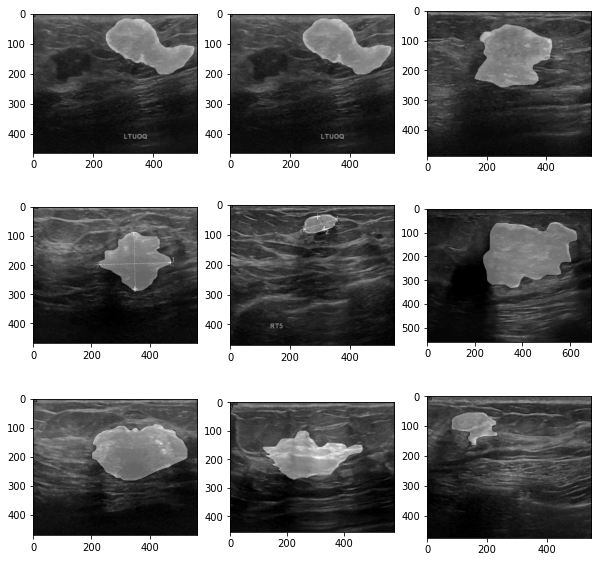

In [ ]:
#Dataset path
datapath = "/content/data/"

#Reading file names
#Masks
masks = [os.path.join(datapath,i) for i in os.listdir(datapath) if "mask" in i]
#Images
imgs = [i.replace("_mask","") for i in masks]
#Creating dataframe of the file names
df = pd.DataFrame({"image":imgs,"mask":masks})
#Creating train/test split in the dataset
df_train, df_val = train_test_split(df,test_size = 0.15)

#Creating a grid of pictures and corresponding masks
#Grid size
rows,cols=3,3
#Figure size
fig=plt.figure(figsize=(10,10))
#Loop over grid size
for i in range(1,rows*cols+1):
  #Pick random integer
  ii = random.randint(0, len(df))
  #Create a subplot 
  fig.add_subplot(rows,cols,i)
  #Fetch image path
  img_path=df['image'][ii]
  #Fetch mask path
  msk_path=df['mask'][ii]
  #Plot the image
  plt.imshow(np.array(Image.open(img_path)), cmap = 'gray')
  #Plot the mask
  plt.imshow(np.array(Image.open(msk_path)),alpha=0.4, cmap = 'gray')
#Display the grid
plt.show()

#Dataset Preparation

In [ ]:
#Function for data augmentation using albumentations module
def trainaugs():
  transform =  [
              #Resize the image
              albumentations.Resize(height=224,width=224,interpolation=Image.BILINEAR),
              #Change brightness and contrast
              albumentations.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0),
              #Shift, Rotate and Scale the image
              albumentations.ShiftScaleRotate(rotate_limit=15, shift_limit=0.15, scale_limit=0.2),
              #Flip the image
              albumentations.HorizontalFlip(),
          ]
  #Return the transformations performed
  return albumentations.Compose(transform)

#Function for transformation performed on validation set
def valaugs():
  transform = [
              #Resize the images
              albumentations.Resize(height=224,width=224,interpolation=Image.BILINEAR),
          ]
  #Return transformed images
  return albumentations.Compose(transform)

#Convert the images to tensor
def convert_to_tensor(x,**kwargs):
  return x.transpose(2,0,1).astype("float32")

#Perform preprocessing on the images based on the passed parameter function
def preprocessing(preprocessing_fn=None):
  transform = []
  #Check if any preprocessing function is passed
  if preprocessing_fn:
    #Perform the preprocessing
    transform.append(albumentations.Lambda(image=preprocessing_fn))
  #Convert the image to tensor
  transform.append(albumentations.Lambda(image=convert_to_tensor))
  #Return the transformed image
  return albumentations.Compose(transform)

#Class for reading the dataset
class GetDataset(Dataset):
  def __init__(self,imagespath,maskspath,augment=None,preprocess=None):
    #Images paths
    self.imagespath = imagespath
    #Masks paths
    self.maskspath = maskspath
    #Augmentation function
    self.augment = augment
    #Preprocessing function
    self.preprocess = preprocess

  #Length of total images    
  def __len__(self):
    return len(self.imagespath)
  
  #Function for reading an image
  def __getitem__(self,idx):
    #Read image
    image = cv2.cvtColor(cv2.imread(self.imagespath[idx]),cv2.COLOR_BGR2RGB)
    #Read the mask
    mask = cv2.imread(self.maskspath[idx], cv2.IMREAD_GRAYSCALE)
    #Check if augmentation required
    if self.augment:
      sample = self.augment(image=image, mask=mask)
      image,mask = sample['image'],sample['mask']
    #Check if preprocessing required
    if self.preprocess:
      sample = self.preprocess(image=image,mask=mask)
      image,mask = sample['image'],sample['mask']
    #Normalization
    mask = (mask / 255).astype(np.float32)
    mask = np.expand_dims(mask, axis=0)
    #Return image and mask
    return image,mask

#Get the training dataset
traindata = GetDataset(imagespath = df_train['image'].tolist(),
                            maskspath = df_train['mask'].tolist(),
                            augment = trainaugs(),
                            preprocess = preprocessing())
#Get the validation dataset
validationdata = GetDataset(imagespath = df_val['image'].tolist(),
                            maskspath = df_val['mask'].tolist(),
                            augment = valaugs(),
                           preprocess = preprocessing())
#Batch size of the images
batch_size = 1
#Creating training dataloader
trainloader = DataLoader(traindata,batch_size = batch_size,shuffle=False)
#Creating validation dataloader
valloader = DataLoader(validationdata,batch_size=batch_size,shuffle=False)

#Model Definition

In [ ]:
#Clone model repository
!git clone 'https://github.com/ZJUGiveLab/UNet-Version.git'

#Load model module
%cd UNet-Version/models/
import UNet
#Declare the model
model = UNet.UNet()
%cd /content/

/content/UNet-Version/models
/content


#Train Model

In [ ]:
#Number of trainign iterations
Epochs = 30
#Learning rate of the model
Learning_rate = 0.001
#Optimization algorithm
optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=Learning_rate)])
#Evaluation metrics
metrics = [ smp.utils.metrics.IoU(threshold=0.5) ]
#Variables to store training and validation metrics
train_logs_list, valid_logs_list = [], []
#Variable to store best iou score
best_iou_score = 0.0
#Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, Epochs)
#Binary Cross Entroy loss function
loss = smp.utils.losses.BCELoss()
#Training and validation step
trainepoch = smp.utils.train.TrainEpoch(model,loss=loss,optimizer=optimizer,metrics=metrics,device="cuda",verbose=True)
validepoch = smp.utils.train.ValidEpoch(model,loss=loss,metrics=metrics,device="cuda",verbose=True)

#Loop over epochs
for i in range(0,Epochs):
    print('\nEpoch: {}'.format(i))
    #Training step
    trainlogs = trainepoch.run(trainloader)
    #Validation step
    validlogs = validepoch.run(valloader)
    #Update learning rate
    lr_scheduler.step()
    #Save training metrics
    train_logs_list.append(trainlogs)
    #Save validation metrics
    valid_logs_list.append(validlogs)
    #Save best model
    if best_iou_score < validlogs['iou_score']:
        best_iou_score = validlogs['iou_score']
        torch.save(model, './best_model.pth')


Epoch: 0
train:   0%|          | 0/177 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


valid: 100%|██████████| 32/32 [00:02<00:00, 11.47it/s, bce_loss - 0.4178, iou_score - 3.553e-11]

Epoch: 1
valid: 100%|██████████| 32/32 [00:02<00:00, 11.48it/s, bce_loss - 0.4162, iou_score - 1.167e-05]

Epoch: 2
valid: 100%|██████████| 32/32 [00:02<00:00, 11.55it/s, bce_loss - 0.4086, iou_score - 6.29e-05]

Epoch: 3
valid: 100%|██████████| 32/32 [00:02<00:00, 11.55it/s, bce_loss - 0.413, iou_score - 6.169e-05]

Epoch: 4
valid: 100%|██████████| 32/32 [00:02<00:00, 11.51it/s, bce_loss - 0.3962, iou_score - 9.921e-06]

Epoch: 5
valid: 100%|██████████| 32/32 [00:02<00:00, 11.45it/s, bce_loss - 0.4034, iou_score - 2.005e-05]

Epoch: 6
valid: 100%|██████████| 32/32 [00:02<00:00, 11.52it/s, bce_loss - 0.4065, iou_score - 0.0001709]

Epoch: 7
valid: 100%|██████████| 32/32 [00:02<00:00, 11.41it/s, bce_loss - 0.3977, iou_score - 0.00749]

Epoch: 8
valid: 100%|██████████| 32/32 [00:02<00:00, 11.49it/s, bce_loss - 0.4005, iou_score - 0.01808]

Epoch: 9
valid: 100%|██████████| 32/32 [00:02<00:00,

#Performance Evaluation

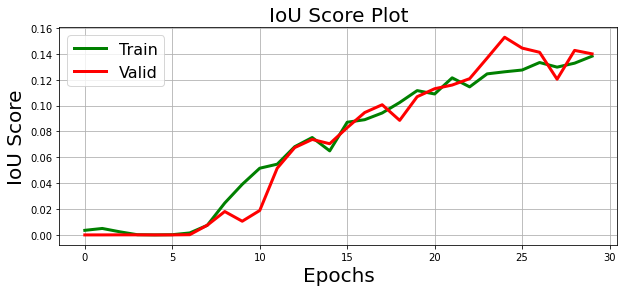

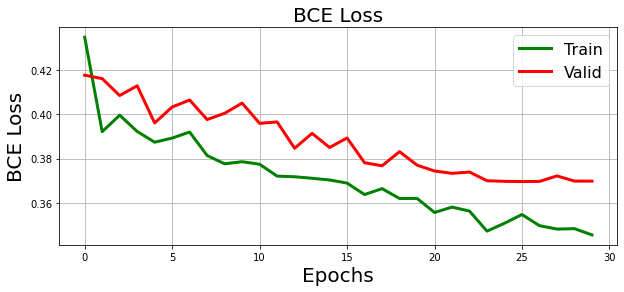

In [ ]:
#Store and create dataframe of evaluation metrics
#Training metrics
train_logs_df = pd.DataFrame(train_logs_list)
#Validation metrics
valid_logs_df = pd.DataFrame(valid_logs_list)

#Plot IoU and Loss scores for training and validation datasets
#Empty figure
plt.figure(figsize=(10,4))
#Plot training IoU score
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(),'g-',lw=3, label = 'Train')
#Plot validation IoU score
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(),'r-' ,lw=3, label = 'Valid')
#X-axis label
plt.xlabel('Epochs', fontsize=20)
#Y-axis label
plt.ylabel('IoU Score', fontsize=20)
#Title of the figure
plt.title('IoU Score Plot', fontsize=20)
#Figure legends
plt.legend(loc='best', fontsize=16)
#Create plot grid
plt.grid()
#Display the plot
plt.show()
#Empty figure
plt.figure(figsize=(10,4))
#Plot training bce loss
plt.plot(train_logs_df.index.tolist(), train_logs_df.bce_loss.tolist(),'g-',lw=3, label = 'Train')
#Plot validation bce loss
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.bce_loss.tolist(),'r-' ,lw=3, label = 'Valid')
#X-axis label
plt.xlabel('Epochs', fontsize=20)
#Y-axis label
plt.ylabel('BCE Loss', fontsize=20)
#Title of the figure
plt.title('BCE Loss', fontsize=20)
#Plot legends
plt.legend(loc='best', fontsize=16)
#Plot grid
plt.grid()
#Display the plot
plt.show()

#Model Prediction

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


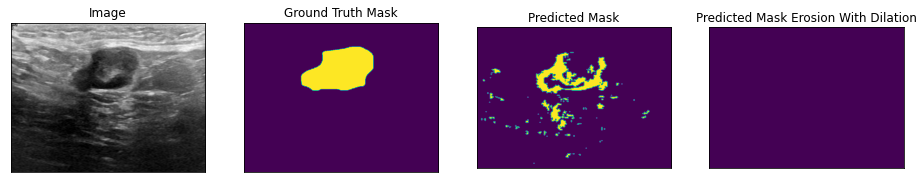

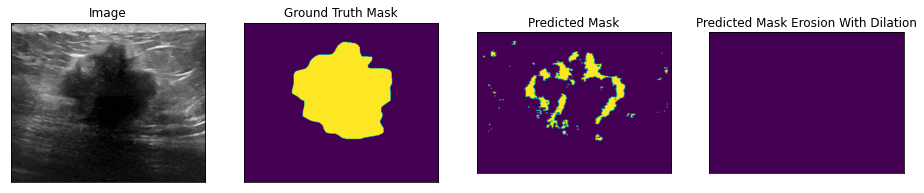

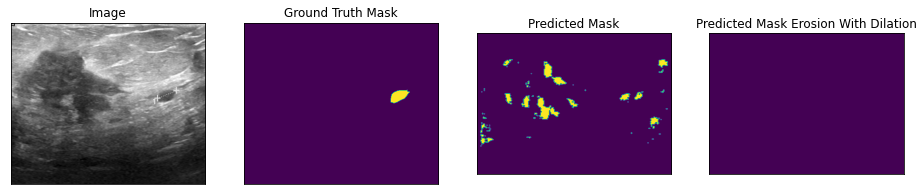

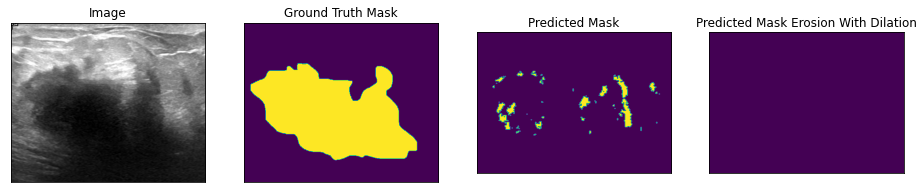

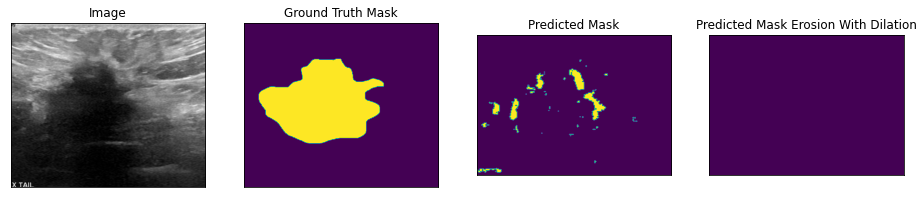

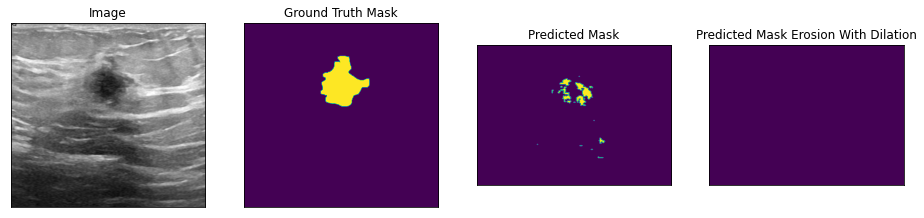

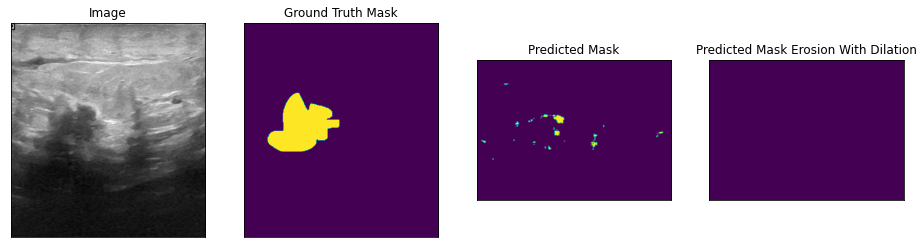

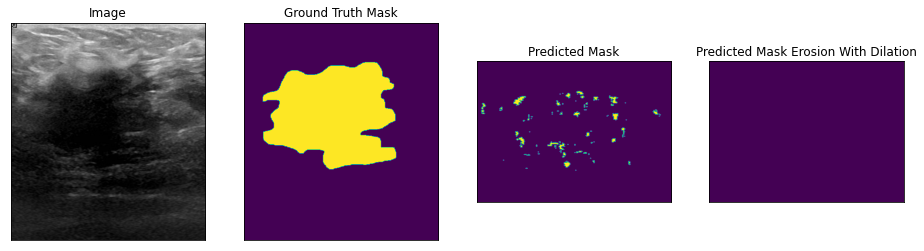

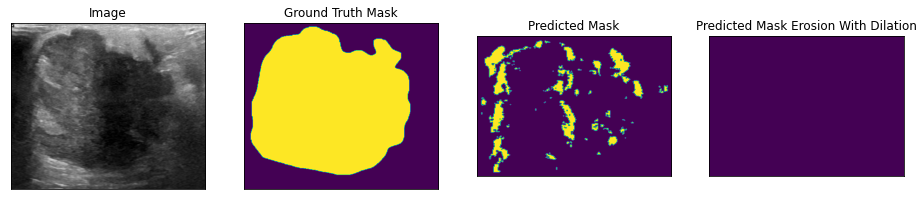

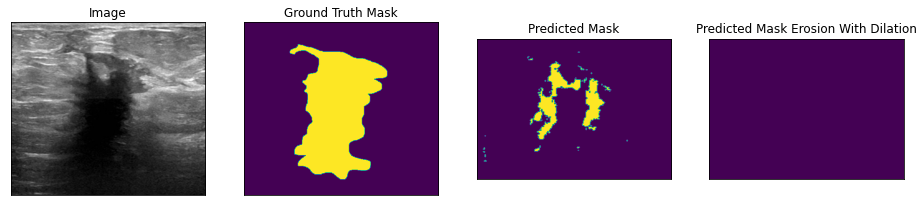

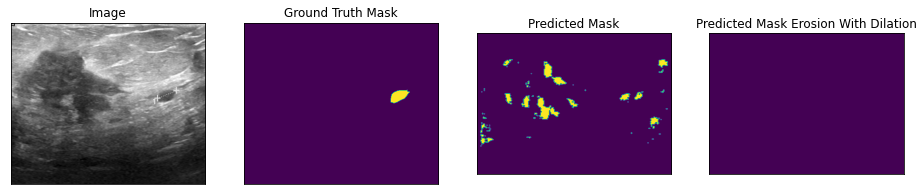

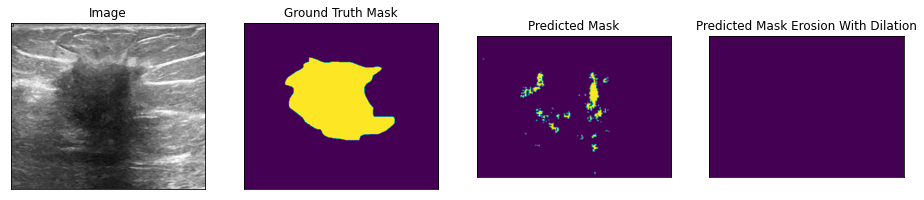

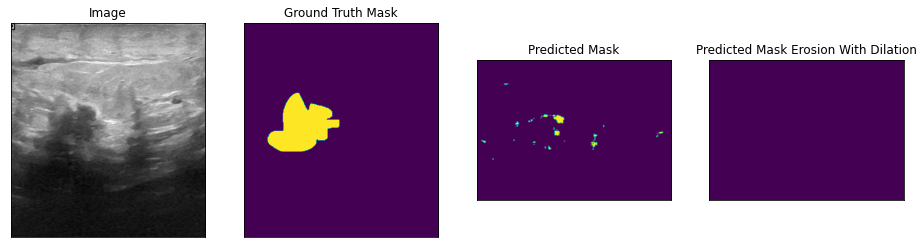

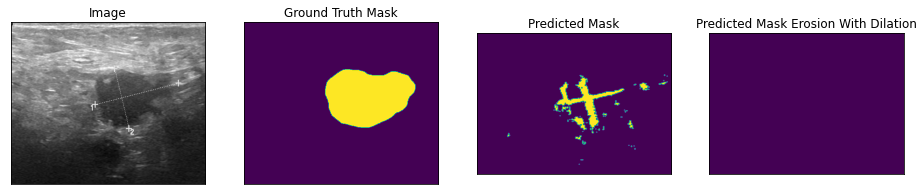

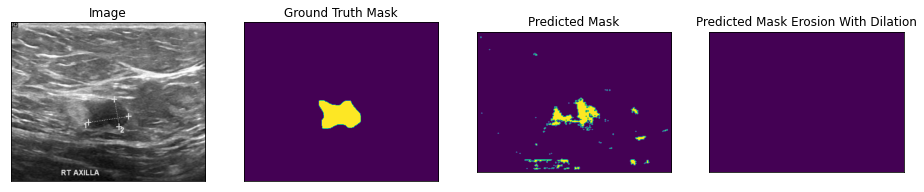

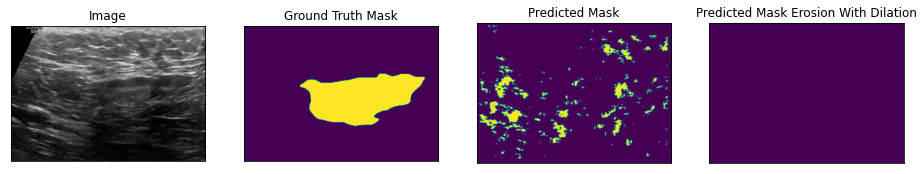

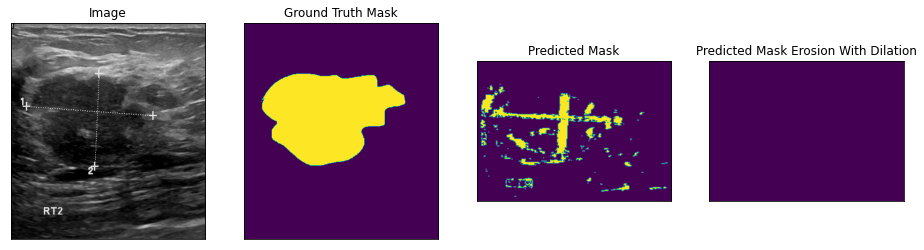

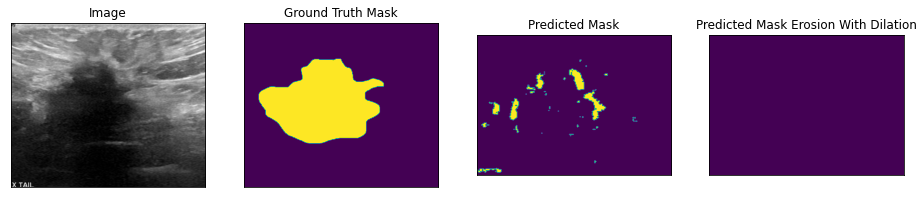

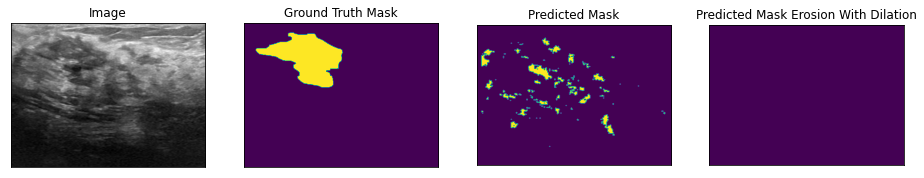

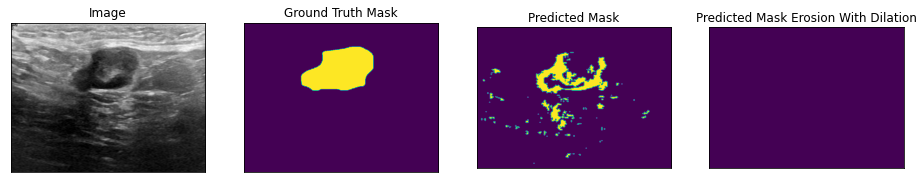

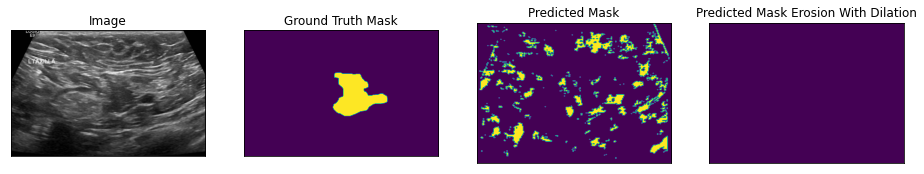

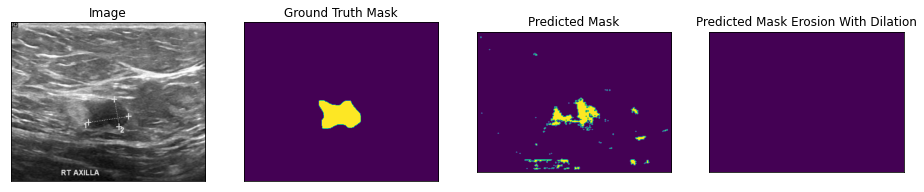

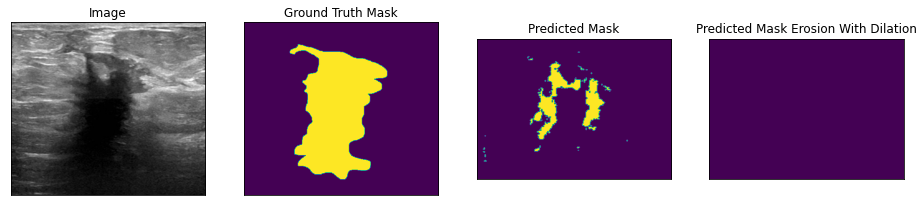

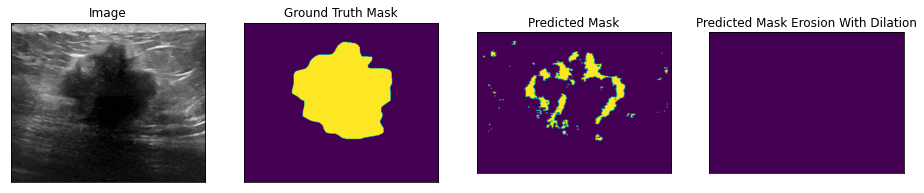

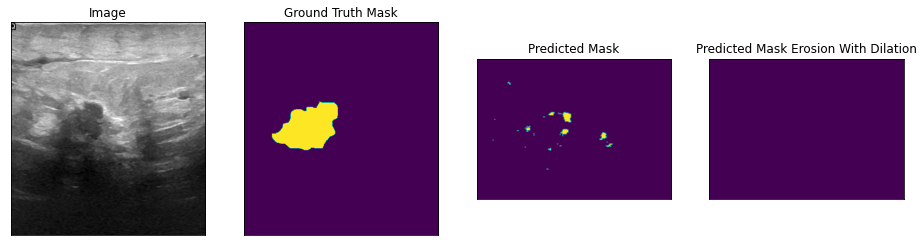

In [ ]:
#Get the best saved model
best_model = torch.load('./best_model.pth')
#Images to visualize from validation set
test_dataset_vis = GetDataset(imagespath = df_val['image'].tolist(),
                            maskspath = df_val['mask'].tolist())
#Function for image and predicted mask visualization
def visualize(**images):
  #Total number of passed images
  n = len(images)
  #Empty figure
  plt.figure(figsize=(16, 5))
  #Iterate over images
  for i, (name, image) in enumerate(images.items()):
    #Create subplot
    plt.subplot(1, n, i + 1)
    #X and Y dimension ticks
    plt.xticks([])
    plt.yticks([])
    #Figure title
    plt.title(' '.join(name.split('_')).title())
    if image.shape[0] == 3:
        image = image.transpose([1, 2, 0])
    plt.imshow(image)
  #Display the image
  plt.show()

#Iterate over 25 random images
for i in range(25):
  #Pick random integer
  n = np.random.choice(len(validationdata))
  #Get the image
  image_vis = test_dataset_vis[n][0].astype('uint8')
  #Get the mask
  mask_vis = test_dataset_vis[n][1].astype('uint8')
  image, gt_mask = validationdata[n]
  gt_mask = gt_mask.squeeze()
  #Convert to tensor
  x_tensor = torch.from_numpy(image).to("cuda").unsqueeze(0)
  #Get model prediction
  pr_mask = best_model(x_tensor)
  pr_mask = pr_mask.squeeze().cpu().detach().numpy().round()
  kernel = np.ones((5,5),np.uint8)
  #Perform erosion and dilation
  pr_mask_er = cv2.erode(pr_mask,kernel,iterations = 4)
  pr_mask_er = cv2.dilate(pr_mask_er,kernel,iterations = 4)
  #Resize the image and mask
  pr_mask = cv2.resize(pr_mask, (580, 420))
  pr_mask_er = cv2.resize(pr_mask_er, (580, 420))
  #Reduce dimension
  mask_vis = mask_vis.squeeze()
  #Plot the image with ground truth and predicted masks
  visualize(
      image=image_vis, 
      ground_truth_mask=mask_vis, 
      predicted_mask=pr_mask,
      predicted_mask_erosion_with_dilation=pr_mask_er
  )

In [ ]:
#Store and create dataframe of evaluation metrics
#Training metrics
train_logs_df

,bce_loss,iou_score
0,0.434980,0.003544
1,0.392206,0.004995
2,0.399675,0.002406
3,0.392308,0.000164
4,0.387437,0.000014
5,0.389316,0.000170
6,0.392037,0.001535
7,0.381405,0.007410
8,0.377658,0.024656
9,0.378605,0.039106


In [ ]:
valid_logs_df

,bce_loss,iou_score
0,0.417800,3.552711e-11
1,0.416224,1.166919e-05
2,0.408581,6.290326e-05
3,0.412986,6.169301e-05
4,0.396163,9.920563e-06
5,0.403376,2.005293e-05
6,0.406537,1.708984e-04
7,0.397689,7.490172e-03
8,0.400529,1.807565e-02
9,0.405167,1.058224e-02
